# bidirectional

> Implementation of bidirectional associative memories.

Bidirectional Associative Memories are a kind of recurrent neural architecture which allows for *bidirectional* recall of stored associated
memory patterns. In particular, we will be implementing the Nonlinear Dynamic Recurrent Associative Memory for Learning Bipolar and Nonpolar
Correlated Patterns (NDRAM) -- a mouthful -- as well as a Bidirectional Heteroassociative Memory (BHM) based on NDRAM.

In [1]:
# | default_exp bidirectional

In [2]:
# | hide
from nbdev.showdoc import *

In [3]:
# | hide
# | export
import equinox as eqx
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
from beartype import beartype as typechecker
from beartype import typing as T
from fastcore.basics import *
from fastcore.meta import *
from jaxtyping import Array, Float, jaxtyped
from einops import rearrange

In [ ]:
# | hide
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [5]:
# | export
@jaxtyped(typechecker=typechecker)
class NDRAM(eqx.Module):
    """Nonlinear Dynamic Recurrent Associative Memory for Learning Bipolar and Nonpolar Correlated Patterns."""

    W: Float[Array, "D D"]  # The weights of the network
    lr: float  # Learning rate parameter
    tr: float  # Transmission parameter

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def weight_update(
        weights: Float[Array, "D D"],  # The weights of the network.
        query_0: Float[Array, " D"],  # The initial query state time t = 0
        query_t: Float[Array, " D"],  # The current query state at time t
        lr: float,  # The learning rate parameter
    ):
        """Perform a weight update."""
        query_0 = rearrange(query_0, "d -> d 1")
        query_t = rearrange(query_t, "d -> d 1")
        return weights + (lr * ((query_0 @ query_0.T) - (query_t @ query_t.T)))

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def query_update(
        weights: Float[Array, "D D"],  # The weights of the network
        query: Float[Array, " D"],  # The query state
        tr: float,  # The transmission parameter
        num_transmissions=1,  # Number of transmissions to perform.
    ):
        """Perform a query update."""

        def update_step(query, _i):
            acts = weights @ query

            def f(a_i):
                """Transmission function on activations."""
                gt_1 = a_i > 1.0
                lt_n1 = a_i < -1.0
                return lax.cond(
                    gt_1,
                    lambda: 1.0,
                    lambda: lax.cond(
                        lt_n1,
                        lambda: -1.0,
                        lambda: ((tr + 1) * a_i) - (tr * (a_i**3)),
                    ),
                )

            query_t = jax.vmap(f)(acts)
            return query_t, None

        iters = np.arange(num_transmissions)
        final_act, _ = lax.scan(update_step, query, iters)
        return final_act

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(self, query: Float[Array, " D"]) -> Float[Array, " D"]:
        """Perform one step recall."""
        return NDRAM.query_update(self.W, query, self.tr)

In [6]:
# | export
@jaxtyped(typechecker=typechecker)
def fit_ndram(
    Xi: Float[Array, "N D"],  # The patterns to learn
    lr: float,  # The learning rate parameter
    tr: float,  # The transmission rate parameter
    num_transmissions: int = 1,  # Optional, number of transmission steps to undertake. Default: `1`.
    nsteps: int = 2_000,  # Number of training steps to undertake. Default: `2_000`.
    key: jax.Array = jr.PRNGKey(0),  # Optional, default `jr.PRNGKey(0)`.
):
    """Fit an NDRAM model to the dataset, returning a trained model."""
    D = Xi.shape[-1]
    init_W = jnp.zeros(shape=(D, D), dtype=jnp.float32)

    def scan_update_step(W, query):
        query_t = NDRAM.query_update(
            W, query, tr=tr, num_transmissions=num_transmissions
        )
        W_t = NDRAM.weight_update(W, query_0=query, query_t=query_t, lr=lr)
        return (W_t, W_t)

    prototypes = jr.choice(key, Xi, shape=(nsteps,))
    final_W, Ws = lax.scan(scan_update_step, init=init_W, xs=prototypes)
    return NDRAM(final_W, lr=lr, tr=tr), None


In [7]:
show_doc(fit_ndram)

---

### fit_ndram

>      fit_ndram (Xi:jaxtyping.Float[Array,'ND'], lr:float, tr:float,
>                 num_transmissions:int=1, nsteps:int=2000,
>                 key:jax.Array=Array([0, 0], dtype=uint32))

*Fit an NDRAM model to the dataset, returning a trained model.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| Xi | Float[Array, 'N D'] |  | The patterns to learn |
| lr | float |  | The learning rate parameter |
| tr | float |  | The transmission rate parameter |
| num_transmissions | int | 1 | Optional, number of transmission steps to undertake. Default: `1`. |
| nsteps | int | 2000 | Number of training steps to undertake. Default: `2_000`. |
| key | Array | [0 0] | Optional, default `jr.PRNGKey(0)`. |

Fit uses the two equations which define the dynamics of NDRAM networks: the weight update rule and the query update rule (1-2) (respectively).
The weight update rule is given by:
$$
W_{(k+1)} = W_{(k)} + \eta \left( x_{(0)} x_{(0)}^T - x_{(t)} x_{(t)}^T \right),
\tag{1}
$$
where $\eta$ is the learning rate parameter, $W_{(k)}$ denotes the weight matrix at time step $k$, $x_{(0)}$ denotes the query buffer at
the initial time step $t = 0$, and $x_{(t)}$ is the current query buffer at time step $t$.

The query update rule is given by:
$$
\begin{align*}
x_i^{(t+1)} &= f(a_i), \\
\text{where}~f(a_i) &= \begin{cases}
    1,&~\text{if}~a_i > 1,\\
    -1,&~\text{if}~a_i < -1, \\
    (\delta + 1)a_i - \delta a_i^3,&~\text{otherwise},
\end{cases}
\end{align*}
\tag{2}
$$
with unfortunately a flipped notation here of $x_i^{(t)}$ denoting the $i$'th element of the query buffer at time $t$, and $\delta$ the *transmission rate*. These are given by
the following methods:

In [8]:
show_doc(NDRAM.weight_update)

---

### NDRAM.weight_update

>      NDRAM.weight_update (weights:jaxtyping.Float[Array,'DD'],
>                           query_0:jaxtyping.Float[Array,'D'],
>                           query_t:jaxtyping.Float[Array,'D'], lr:float)

*Perform a weight update.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| weights | Float[Array, 'D D'] | The weights of the network. |
| query_0 | Float[Array, 'D'] | The initial query state time t = 0 |
| query_t | Float[Array, 'D'] | The current query state at time t |
| lr | float | The learning rate parameter |

In [9]:
show_doc(NDRAM.query_update)

---

### NDRAM.query_update

>      NDRAM.query_update (weights:jaxtyping.Float[Array,'DD'],
>                          query:jaxtyping.Float[Array,'D'], tr:float,
>                          num_transmissions=1)

*Perform a query update.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| weights | Float[Array, 'D D'] |  | The weights of the network |
| query | Float[Array, 'D'] |  | The query state |
| tr | float |  | The transmission parameter |
| num_transmissions | int | 1 | Number of transmissions to perform. |

# Example

In [10]:
DATA_DIR = "../data/mnist"

pxw, pxh = 28, 28


def transform(data):
    data = np.array(data, dtype=jnp.float64)
    data = rearrange(data, "w h -> (w h)")
    data[data > 0.0] = 1.0
    data[data == 0.0] = -1.0
    return data


mnist_train = MNIST(DATA_DIR, train=True, transform=transform)
mnist_data_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_it = iter(mnist_data_loader)
mnist_data, _ = next(mnist_it)

In [11]:
def mask(
    state: Float[Array, " D"], pct_mask: float = 0.3, key: jax.Array = jr.PRNGKey(11)
) -> Float[Array, " D"]:
    prange = np.array([pct_mask, 1 - pct_mask])
    return state * jr.choice(key, np.array([-1, 1]), p=prange, shape=state.shape)
    # noise = jr.normal(key, shape=(pxh* pxw,))
    # return query * noise


def show_im(im: Float[Array, " WH"], title: str = "") -> None:
    im = im * 255.0
    im = rearrange(im, "(w h) -> w h", w=pxw, h=pxh)
    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])


def show_weights(W, title=""):
    W = jax.block_until_ready(W).__array__()
    plt.imshow(W, cmap="viridis", aspect="auto")
    plt.title(title)
    plt.xticks([])
    plt.yticks([])


def display_pair(img1, img2, titles=["", ""]):
    images = [jnp.array(img).reshape(28, 28) for img in [img1, img2]]
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


def display_recall(
    img1,
    img2,
    img3,
    titles=[
        "",
        "",
        "",
    ],
):
    images = [
        jnp.array(img).reshape(28, 28)
        for img in [
            img1,
            img2,
            img3,
        ]
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


Xi = jnp.array(mnist_data[:13])
lr = 0.001
tr = 0.1
ndram, Ws = fit_ndram(Xi, lr, tr)
# show_weights(ndram.W, "Trained Weights")

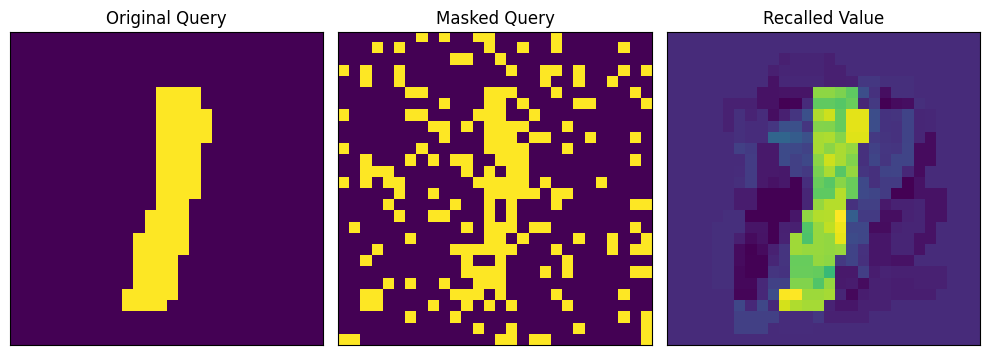

In [12]:
query = Xi[9]
masked_query = mask(query, pct_mask=0.2, key=jr.PRNGKey(11))
est_query = ndram(masked_query)

display_recall(
    query, masked_query, est_query, ["Original Query", "Masked Query", "Recalled Value"]
)

# Bidirectional Heteroassociative Memory for Binary and Grey-level Patterns

Similar to the above, we will be implementing another associative memory, except this time it will be a *Bidirectional*
and *Heteroassociative*. An associative memory is *bidirectional* if it stores queries and targets, $(x, y)$, and recall
$\mathcal{M}(x) = y$ and $\mathcal{M}(y) = x$. An associative memory is *heteroassociative* (i.e., a *heteroassociative memory*)
if $x \neq y$. The specific model is the Bidirectional Heteroassociative Memory (BAM), from [Chartier & Boukadoum (2006)](https://pubmed.ncbi.nlm.nih.gov/16566466/).
Like NDRAM, BAM uses an *online* learning rule. In honor of the first author, we will be denoting this class
with the name `Chartier`.

In [13]:
# | export
@jaxtyped(typechecker=typechecker)
class Chartier(eqx.Module):
    """Bidirectional Hetero-associative Memory."""

    W: Float[Array, "D D"]  # "Forward" weights
    V: Float[Array, "D D"]  # "Backward" weights
    lr: float  # Learning rate parameter
    tr: float  # Transmission parameter

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def forward_weight_update(
        W: Float[Array, "D D"],  # The "forward" weights
        x_0: Float[Array, " D"],  # Initial query, i.e. query at time `t = 0`
        x_t: Float[Array, " D"],  # Query at time `t`
        y_0: Float[Array, " D"],  # Initial target, target at time `t = 0`.
        y_t: Float[Array, " D"],  # Target at time `t`.
        lr: float,  # Learning rate parameter
    ) -> Float[Array, "D D"]:  # Updated "forward" weights
        """Forward weight update."""
        x_0 = rearrange(x_0, "d -> d 1")
        x_t = rearrange(x_t, "d -> d 1")
        y_0 = rearrange(y_0, "d -> d 1")
        y_t = rearrange(y_t, "d -> d 1")
        W_t = W + lr * (y_0 - y_t) @ (x_0 - x_t).T
        return W_t

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def backward_weight_update(
        V: Float[Array, "D D"],  # The "backward" weights
        x_0: Float[Array, " D"],  # Initial query, i.e. query at time `t = 0`
        x_t: Float[Array, " D"],  # Query at time `t`
        y_0: Float[Array, " D"],  # Initial target, target at time `t = 0`.
        y_t: Float[Array, " D"],  # Target at time `t`.
        lr: float,  # Learning rate parameter
    ) -> Float[Array, "D D"]:  # Updated backward weights
        x_0 = rearrange(x_0, "d -> d 1")
        x_t = rearrange(x_t, "d -> d 1")
        y_0 = rearrange(y_0, "d -> d 1")
        y_t = rearrange(y_t, "d -> d 1")
        V_t = V + lr * (x_0 - x_t) @ (y_0 - y_t).T
        return V_t

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def _forward_prediction(
        W: Float[Array, "D D"],  # The "forward" weights
        x_0: Float[Array, " D"],  # The forward query
        tr: float,  # The transmission rate
        num_transmissions: int = 1,  # The number of transmissions to perform
    ) -> Float[Array, " D"]:  # The recalled value, after `num_transmissions`
        """Retrieve an estimated target from a query."""

        def update_step(query, _i):
            acts = W @ query

            def f(a_i):
                """Transmission function on activations."""
                gt_1 = a_i > 1.0
                lt_n1 = a_i < -1.0
                return lax.cond(
                    gt_1,
                    lambda: 1.0,
                    lambda: lax.cond(
                        lt_n1,
                        lambda: -1.0,
                        lambda: ((tr + 1) * a_i) - (tr * (a_i**3)),
                    ),
                )

            query_t = jax.vmap(f)(acts)
            return query_t, None

        iters = np.arange(num_transmissions)
        final_act, _ = lax.scan(update_step, x_0, iters)
        return final_act

    @staticmethod
    @jaxtyped(typechecker=typechecker)
    def _backward_prediction(
        W: Float[Array, "D D"],  # The "backward" weights
        y_0: Float[Array, " D"],  # The backward query
        tr: float,  # The transmission rate
        num_transmissions: int = 1,  # The number of transmissions to perform
    ) -> Float[Array, " D"]:  # The recalled value, after `num_transmissions`
        """Retrieve an estimated target from a query."""

        def update_step(query, _i):
            acts = W @ query

            def f(a_i):
                """Transmission function on activations."""
                gt_1 = a_i > 1.0
                lt_n1 = a_i < -1.0
                return lax.cond(
                    gt_1,
                    lambda: 1.0,
                    lambda: lax.cond(
                        lt_n1,
                        lambda: -1.0,
                        lambda: ((tr + 1) * a_i) - (tr * (a_i**3)),
                    ),
                )

            query_t = jax.vmap(f)(acts)
            return query_t, None

        iters = np.arange(num_transmissions)
        final_act, _ = lax.scan(update_step, y_0, iters)
        return final_act

    @jaxtyped(typechecker=typechecker)
    def forward_pred(
        self,
        x: Float[Array, " D"],  # The forward query.
        num_transmissions: int = 1,  # The number of transmissions to perform.
    ) -> Float[Array, " D"]:  # The recalled target after `num_transmissions`
        """Perform "forwards" recall."""
        return Chartier._forward_prediction(
            self.W, x, tr=self.tr, num_transmissions=num_transmissions
        )

    @jaxtyped(typechecker=typechecker)
    def backward_pred(
        self,
        y: Float[Array, " D"],  # The backwards query
        num_transmissions: int = 1,  # The number of transmissions to perform
    ) -> Float[Array, " D"]:  # The recalled query after `num_transmissions`.
        """Perform "backwards" recalll."""
        return Chartier._backward_prediction(
            self.V, y, tr=self.tr, num_transmissions=num_transmissions
        )

In [14]:
# | export
@jaxtyped(typechecker=typechecker)
def fit_chartier(
    A: Float[Array, "N D"],  # The "address" matrix of patterns to store
    P: Float[Array, "N D"],  # The "backwards" matrix of patterns to store
    lr: float,  # The learning rate
    tr: float,  # The transmission rate
    nsteps: int = 2_000,  # The number of learning steps to perform
    num_transmissions: int = 1,  # The number of transmission steps to perform
    key: jax.Array = jr.PRNGKey(0),  # Optional, default `jr.PRNGKey(0)`
):
    """Create and fit a `Chartier` network to the address and pattern matrices `A` and `P`."""
    N, D = A.shape
    M = P.shape[-1]
    init_W = jnp.zeros(shape=(D, D), dtype=jnp.float32)
    init_V = jnp.zeros(shape=(M, M), dtype=jnp.float32)

    def scan_update_step(weights, i):
        W, V = weights
        x_0 = A[i, :]
        y_0 = P[i, :]
        y_t = Chartier._forward_prediction(
            W, x_0, tr=tr, num_transmissions=num_transmissions
        )
        x_t = Chartier._backward_prediction(
            V, y_0, tr=tr, num_transmissions=num_transmissions
        )
        W_t = Chartier.forward_weight_update(W, x_0, x_t, y_0, y_t, lr)
        V_t = Chartier.backward_weight_update(V, x_0, x_t, y_0, y_t, lr)
        return (W_t, V_t), None

    idxs = jr.choice(key, jnp.arange(N), shape=(nsteps,))
    (final_W, final_V), _ = lax.scan(scan_update_step, init=(init_W, init_V), xs=idxs)
    return Chartier(final_W, final_V, tr, lr)

In [15]:
show_doc(Chartier.forward_weight_update)

---

### Chartier.forward_weight_update

>      Chartier.forward_weight_update (W:jaxtyping.Float[Array,'DD'],
>                                      x_0:jaxtyping.Float[Array,'D'],
>                                      x_t:jaxtyping.Float[Array,'D'],
>                                      y_0:jaxtyping.Float[Array,'D'],
>                                      y_t:jaxtyping.Float[Array,'D'], lr:float)

*Forward weight update.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| W | Float[Array, 'D D'] | The "forward" weights |
| x_0 | Float[Array, 'D'] | Initial query, i.e. query at time `t = 0` |
| x_t | Float[Array, 'D'] | Query at time `t` |
| y_0 | Float[Array, 'D'] | Initial target, target at time `t = 0`. |
| y_t | Float[Array, 'D'] | Target at time `t`. |
| lr | float | Learning rate parameter |
| **Returns** | **Float[Array, 'D D']** | **Updated "forward" weights** |

In [16]:
show_doc(Chartier.backward_weight_update)

---

### Chartier.backward_weight_update

>      Chartier.backward_weight_update (V:jaxtyping.Float[Array,'DD'],
>                                       x_0:jaxtyping.Float[Array,'D'],
>                                       x_t:jaxtyping.Float[Array,'D'],
>                                       y_0:jaxtyping.Float[Array,'D'],
>                                       y_t:jaxtyping.Float[Array,'D'],
>                                       lr:float)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| V | Float[Array, 'D D'] | The "backward" weights |
| x_0 | Float[Array, 'D'] | Initial query, i.e. query at time `t = 0` |
| x_t | Float[Array, 'D'] | Query at time `t` |
| y_0 | Float[Array, 'D'] | Initial target, target at time `t = 0`. |
| y_t | Float[Array, 'D'] | Target at time `t`. |
| lr | float | Learning rate parameter |
| **Returns** | **Float[Array, 'D D']** | **Updated backward weights** |

In [17]:
show_doc(Chartier.forward_pred)

---

### Chartier.forward_pred

>      Chartier.forward_pred (x:jaxtyping.Float[Array,'D'],
>                             num_transmissions:int=1)

*Perform "forwards" recall.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| x | Float[Array, 'D'] |  | The forward query. |
| num_transmissions | int | 1 | The number of transmissions to perform. |
| **Returns** | **Float[Array, 'D']** |  | **The recalled target after `num_transmissions`** |

In [18]:
show_doc(Chartier.backward_pred)

---

### Chartier.backward_pred

>      Chartier.backward_pred (y:jaxtyping.Float[Array,'D'],
>                              num_transmissions:int=1)

*Perform "backwards" recalll.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| y | Float[Array, 'D'] |  | The backwards query |
| num_transmissions | int | 1 | The number of transmissions to perform |
| **Returns** | **Float[Array, 'D']** |  | **The recalled query after `num_transmissions`.** |

`Chartier` models are created using `fit_chartier`. This trains the model using the following procedure:
1. Select a random query-target pair,
2. Compute their updated forms via the pattern update rule,
3. Compute the updated weight matrices given these values, and,
4. Repeat the steps for the number of steps provided.

# Example

In [19]:

A_mnist_data_loader = DataLoader(mnist_train, batch_size=13, shuffle=True)
A_mnist_it = iter(mnist_data_loader)
A, _ = next(mnist_it)
A = jnp.array(A)

P_mnist_data_loader = DataLoader(mnist_train, batch_size=13, shuffle=True)
P_mnist_it = iter(mnist_data_loader)
P, _ = next(mnist_it)
P = jnp.array(P)

lr = 0.001
tr = 0.1
chartier = fit_chartier(A, P, lr=lr, tr=tr, nsteps=2_000)

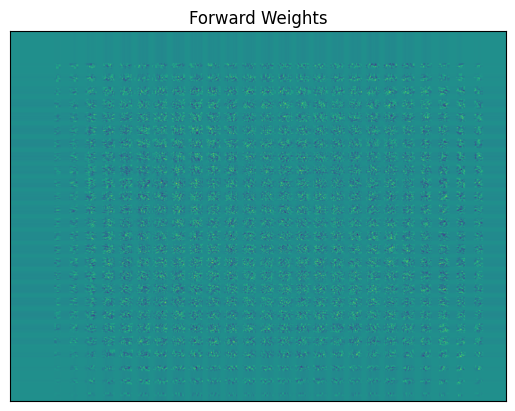

In [20]:
show_weights(chartier.W, "Forward Weights")

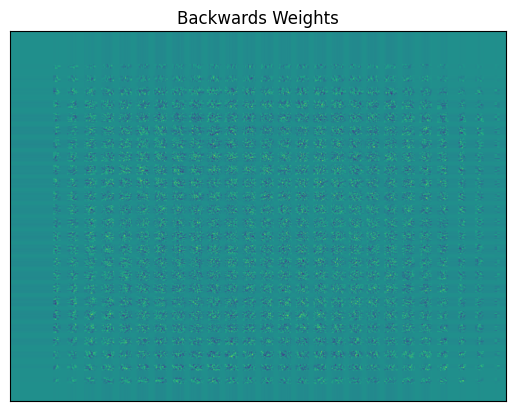

In [21]:
show_weights(chartier.V, "Backwards Weights")

## Example Recall

In order to test whether the system works, we will perform a forwards and backwards recall for associated patterns.

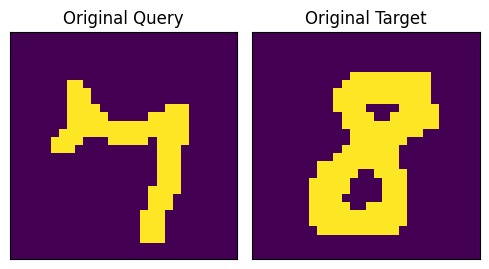

In [22]:
def display_chartier_recall(img1, img2, img3, img4, titles=["", "", "", ""]):
    images = [jnp.array(img).reshape(28, 28) for img in [img1, img2, img3, img4]]
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


query, target = A[0], P[0]
masked_query, masked_target = mask(query, 0.25), mask(target, 0.25)
display_pair(query, target, ["Original Query", "Original Target"])

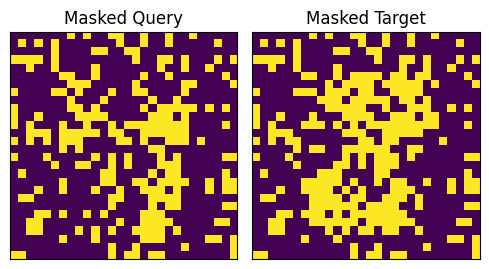

In [23]:
display_pair(masked_query, masked_target, ["Masked Query", "Masked Target"])

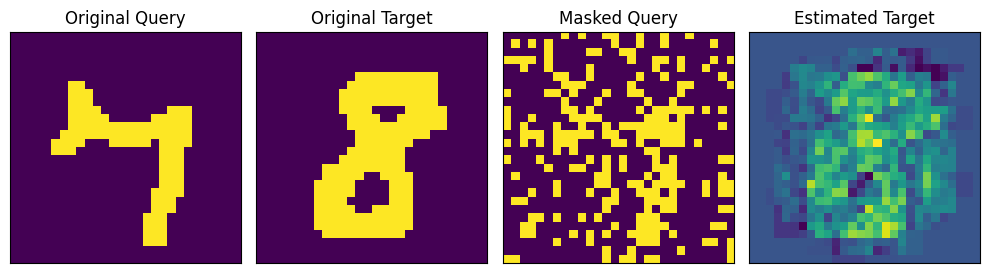

In [24]:
est_target = chartier.forward_pred(masked_query)
display_chartier_recall(
    query,
    target,
    masked_query,
    est_target,
    ["Original Query", "Original Target", "Masked Query", "Estimated Target"],
)

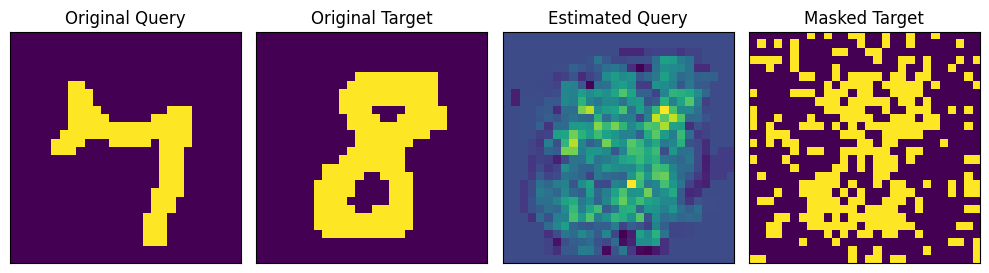

In [25]:
est_query = chartier.backward_pred(masked_target)
display_chartier_recall(
    query,
    target,
    est_query,
    masked_target,
    ["Original Query", "Original Target", "Estimated Query", "Masked Target"],
)

In [26]:
# | hide
import nbdev

nbdev.nbdev_export()